# Setup

## Imports

In [1]:
import IPython.display as display
import os.path
import itertools
import librosa

from glob import glob
from tqdm import tqdm_notebook as tqdm
from matplotlib.ticker import ScalarFormatter

PyTorch Modules

In [2]:
import torch
import torch.nn.functional as F

from torch.autograd import Variable

vai Modules

In [3]:
from vai_.utils.utils import randpick
from vai_.io import pickle_load

Local Modules

In [4]:
from wavenet_utils import *

## Checks

In [5]:
assert os.path.exists(os.path.join(DIR_CHECKPOINTS, 'model.pt')), 'Training not done! Run Train notebook first'

In [6]:
assert os.path.exists(os.path.join(DIR_CHECKPOINTS, 'data.npz')), 'Training data not saved. Run Train notebook first'

## Hyperparameters

In [7]:
num_layers = 9
num_stacks = 2

In [8]:
receptive_field = num_stacks * (2 ** num_layers - 1) + 2
frame_size = receptive_field

In [9]:
dilation_channels = 16
residual_channels = 32
skip_channels = 512
end_channels = 256

In [10]:
bias = False

Fixed

In [11]:
use_gpu = True
num_classes = 256
soft = True
val_split = 0.2
sampling_rate = 16000

## Define Useful Features

In [12]:
cuda = lambda x: x.cuda() if torch.cuda.is_available() and use_gpu else x

In [13]:
DIR_DATA = DIR_DATA['LJSpeech']

In [14]:
def categorize(x):
    bins = np.linspace(-1, 1, num_classes, dtype=x.dtype)
    
    x = mu_law(x)
    if soft:
        return gaussian_filter(x, bins, std=2. / num_classes)
    else:
        x = np.minimum(np.digitize(x, bins), num_classes - 1)
        return one_hot(x, num_classes)

In [15]:
def decategorize(x, temperature=1, probabilistic=False):
    bins = np.linspace(-1, 1, num_classes, dtype=x.dtype)
    
    if soft and not probabilistic:
        epsilon = 1e-12
        return inv_mu_law(softmax(np.log(x + epsilon) / temperature).dot(bins))
    else:
        if probabilistic:
            idx = np.array([np.random.choice(np.arange(num_classes), p=p) for p in x])
        else:
            idx = x.argmax(-1)

        return inv_mu_law(bins[idx])

In [16]:
hear = lambda x: display.Audio(x, rate=sampling_rate)

In [17]:
def plot_metric(y_axis='loss', x_axis='running_epoch', log_scale=True):
    metric = history[y_axis]
    last_metric = metric[-1]
    max_metric = max(metric)
    min_metric = min(metric)
    legend_str = 'e' if np.log10(last_metric) < -2 else 'f'
    legend_str = ('last {} {:.2' + legend_str + '}').format(y_axis, last_metric)
    
    plot(history[x_axis], metric, label=legend_str)
    
    if log_scale:
        plt.yscale('log')
        if min_metric < 2:
            new_yticks = np.concatenate([np.array([min_metric]), np.array([max_metric]), 10 ** np.arange(np.ceil(np.log10(max_metric)), 1), (np.arange(2, np.ceil(max_metric)))])
        else:
            new_yticks = np.concatenate([np.array([min_metric]), np.arange(np.ceil(min_metric), np.ceil(max_metric))])
            
        plt.gca().set_yticks(new_yticks)
        plt.gca().get_yaxis().set_major_formatter(ScalarFormatter())
        plt.gca().minorticks_off()
    
    plt.legend()
    plt.title('vs {}'.format(x_axis))

## Load Data

In [18]:
filenames = sorted(glob(os.path.join(DIR_DATA, 'wavs', '*.wav')))

Play sample audio

In [19]:
sample_audio = librosa.load(randpick(filenames), sampling_rate)[0]
sample_audio = sample_audio[:len(sample_audio)//frame_size*frame_size]

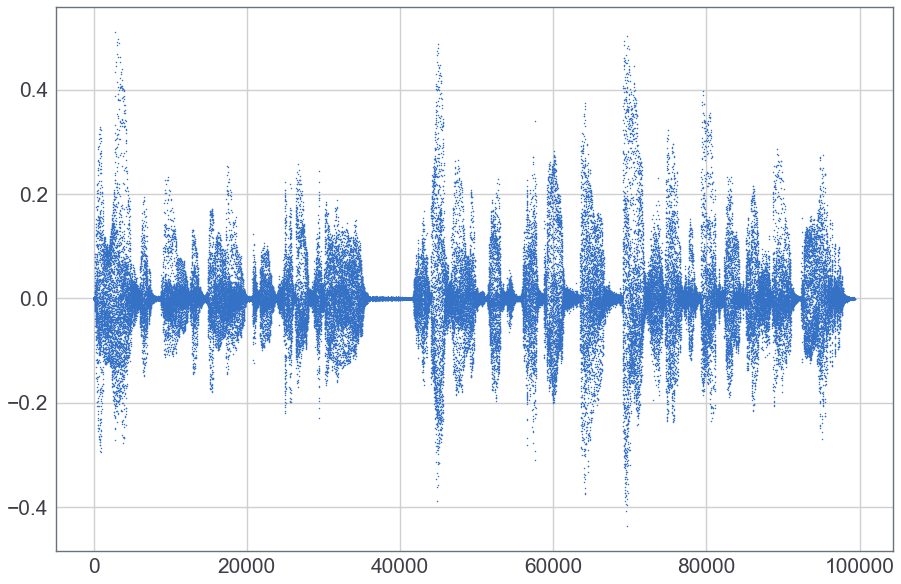

In [20]:
plot(sample_audio, '.', markersize=3)
hear(sample_audio)

In [21]:
data = np.load(os.path.join(DIR_CHECKPOINTS, 'data.npz'))['data']

In [22]:
val_idx = int(len(data) * (1 - val_split))
data_val = data[val_idx:]
data = data[:val_idx]
del val_idx

# Define Model

A Residual Block which is repeated many times over as a stack

In [23]:
class ResBlock(nn.Module):
    def __init__(self, dilation=1, res_connect=True):
        super().__init__()
        self.conv_tanh = CausalConv1d(residual_channels, dilation_channels, 2, dilation, bias=bias)
        self.conv_sigmoid = CausalConv1d(residual_channels, dilation_channels, 2, dilation, bias=bias)
        self.conv_skip = CausalConv1d(dilation_channels, skip_channels, 1, bias=bias)
        
        self.res_connect = res_connect
        if res_connect: self.conv_res = CausalConv1d(dilation_channels, residual_channels, 1, bias=bias)
        
    def forward(self, x):
        x_tanh = F.tanh(self.conv_tanh(x))
        x_sigmoid = F.sigmoid(self.conv_sigmoid(x))
        out = x_tanh * x_sigmoid
        skip = self.conv_skip(out)
        res = self.conv_res(out) + x if self.res_connect else skip
        return res, skip

In [24]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CausalConv1d(num_classes, residual_channels, 2, bias=bias)
        self.conv2 = CausalConv1d(skip_channels, end_channels, 1, bias=bias)
        self.conv3 = CausalConv1d(end_channels, num_classes, 1, bias=bias)
        
        dilations = list(itertools.chain(*[[2 ** i for i in range(num_layers)] for _ in range(num_stacks)]))
        self.res_layers = nn.ModuleList([ResBlock(dilation) for dilation in dilations[:-1]])
        self.res_layers.append(ResBlock(dilations[-1], res_connect=False))
        
    def forward(self, x):
        res = self.conv1(x)
        
        skip_total = 0
        for i in range(len(self.res_layers)):
            res, skip = self.res_layers[i](res)
            skip_total += skip
            
        out = F.leaky_relu(skip_total, 0.2, True)
        out = F.leaky_relu(self.conv2(out), 0.2, True)
        out = self.conv3(out)
        return out

In [25]:
model = cuda(Model())

In [26]:
criterion = nn.CrossEntropyLoss()

In [27]:
def cross_entropy(output, target):
    if soft:
        return -(target * F.log_softmax(output, -1)).sum(-1).mean()
    else:
        return criterion(output, target.max(-1)[1])

In [28]:
model.load_state_dict(torch.load(os.path.join(DIR_CHECKPOINTS, 'model.pt')))
history = pickle_load(os.path.join(DIR_CHECKPOINTS, 'history.p'))

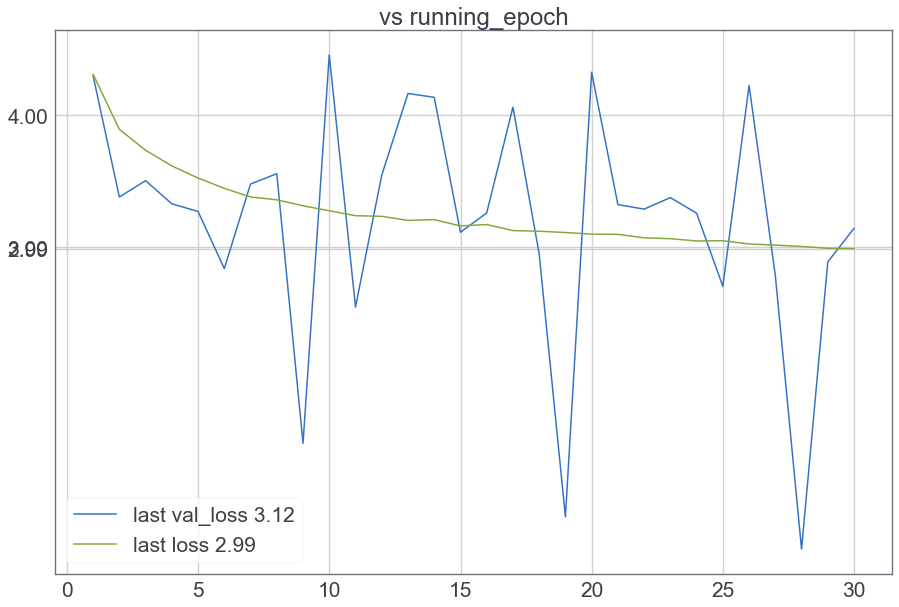

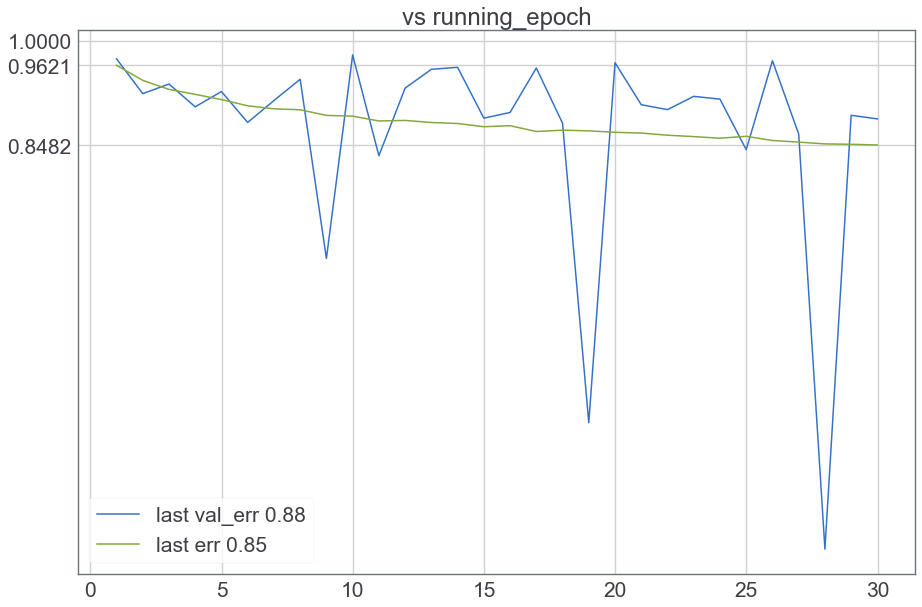

In [29]:
plot_metric('val_loss')
plot_metric()
plt.show()
plot_metric('val_err')
plot_metric('err')

# Sample

In [30]:
%%capture
model.eval()

## Sanity Check

In [31]:
def sanity_check():
    x = data[np.random.randint(len(data))]
    x = categorize(x[:frame_size + 1])

    _input = x[:-1].T.reshape(1, num_classes, frame_size)
    target = x[-1:]

    _input = Variable(cuda(torch.from_numpy(_input)), volatile=True)

    target = Variable(cuda(torch.from_numpy(target)), volatile=True)

    output = model(_input)[:, :, -1:]
    output = torch.transpose(output, 1, 2).contiguous().view(-1, 256)
    loss = cross_entropy(output, target)

    print('Loss is:', loss.data.cpu().numpy()[0])

In [32]:
sanity_check()

Loss is: 5.2823677


## Generate Audio

In [33]:
def generate_audio(seed=None, time=2, probabilistic=False, skip_draw=None):
    if type(skip_draw) is int:
        %matplotlib notebook
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(seed)
        line, = ax.plot(len(seed) - 1, seed[-1], 'g')

    if seed is not None:
        generated_audio = categorize(seed)
        if len(generated_audio) < frame_size:
            generated_audio = np.vstack([np.zeros((frame_size - len(generated_audio), num_classes), dtype=generated_audio.dtype), generated_audio])
    else:
        generated_audio = np.zeros((frame_size, num_classes), np.float32)
        generated_audio[np.arange(frame_size), np.random.randint(0, num_classes, frame_size)] = 1
    
    total_length = len(generated_audio) + int(time * sampling_rate)
    plt.xlim((0, total_length))
    plt.ylim((-1, 1))
    
    if len(generated_audio) >= frame_size:
        _input = generated_audio[-frame_size:, :]
    else:
        _input = generated_audio
        
    _input = np.expand_dims(_input, 0)
    _input = np.transpose(_input, [0, 2, 1])
    _input = Variable(cuda(torch.from_numpy(_input)), volatile=True)
    
    start_idx = len(generated_audio)
    generated_audio = np.vstack([generated_audio, np.zeros((total_length - len(generated_audio), num_classes), np.float32)])
    
    for i in tqdm(range(start_idx, total_length)):
        output = model(_input)[:, :, -1:]
        output = F.softmax(output, 1)
        generated_audio[i] = output.data.cpu().numpy()[0].T
        _input.data = torch.cat([_input.data, output.data], -1)[:, :, 1:]
        
        if type(skip_draw) is int and i % skip_draw == 0:
            index = decategorize(generated_audio[i-skip_draw:i], probabilistic=probabilistic)
            line.set_xdata(np.append(line.get_xdata(), np.arange(i-skip_draw, i)))
            line.set_ydata(np.append(line.get_ydata(), index))
            plt.title(index.mean())
            fig.canvas.draw()
    
    aud = decategorize(generated_audio, probabilistic=probabilistic)
    
    if type(skip_draw) is not int:
        %matplotlib inline
        jtplot.style(figsize=(15, 10), fscale=2, context='notebook')
        plot(np.arange(start_idx), aud[:start_idx])
        plot(np.arange(start_idx+1, len(aud)), aud[start_idx+1:])
    
    return aud

In [34]:
idx = np.random.randint(len(data))
seed = data[idx]
aud = seed.copy()

<IPython.core.display.Javascript object>


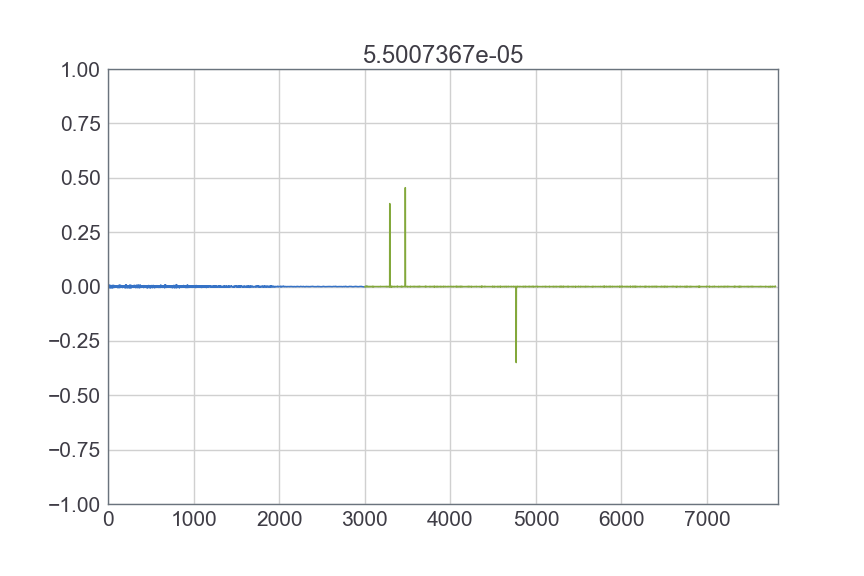

HBox(children=(IntProgress(value=0, max=4800), HTML(value='')))

<IPython.core.display.Javascript object>


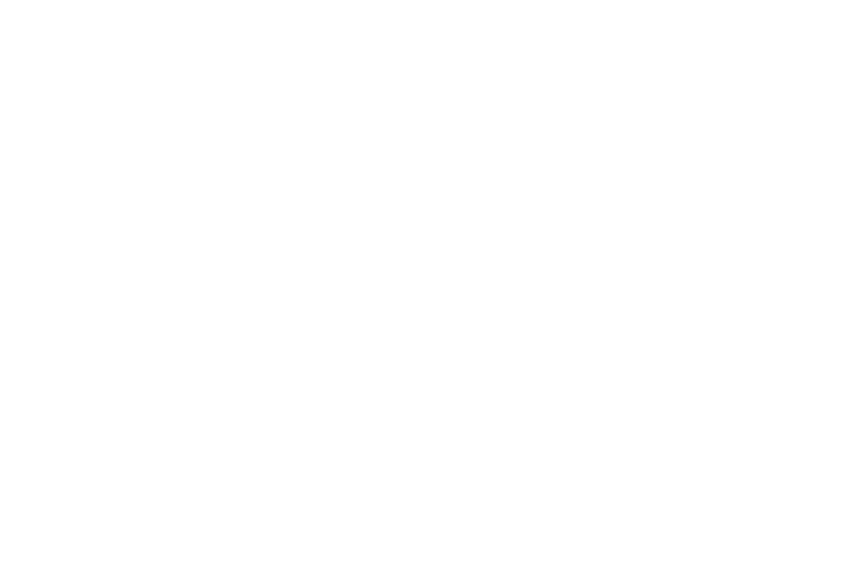

In [35]:
aud = generate_audio(aud, 0.3, probabilistic=True, skip_draw=100)
hear(aud)

## Validation

In [36]:
idx = np.random.randint(len(data_val))
seed = data_val[idx]
aud = seed.copy()

<IPython.core.display.Javascript object>


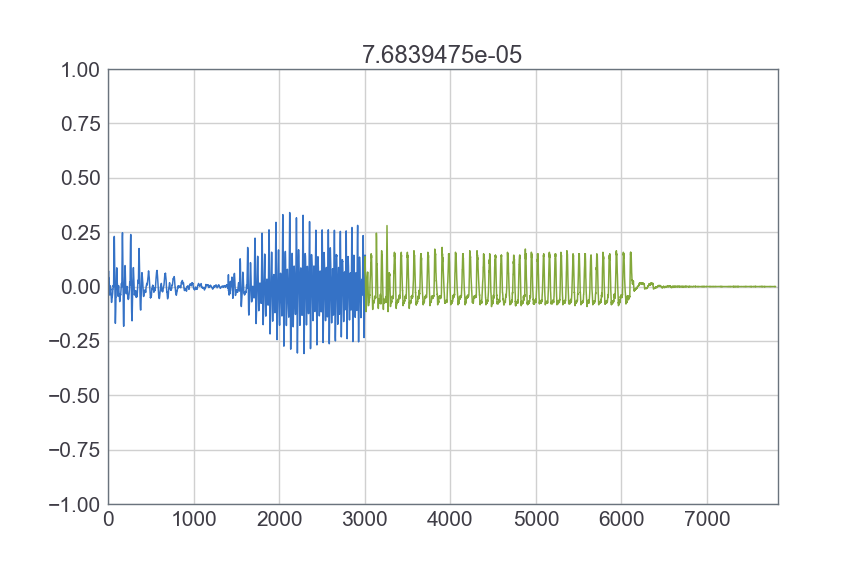

HBox(children=(IntProgress(value=0, max=4800), HTML(value='')))

In [37]:
aud = generate_audio(aud, 0.3, probabilistic=True, skip_draw=100)
hear(aud)